## Data Wrangling

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import utility
import math

EXPERIEMENT_SEED = 42
np.random.seed(EXPERIEMENT_SEED)

In [2]:
weather_df = utility.get_processed_dataset()
weather_df.head(4)

,pyranometer,pyroheliometer,azimuth_angle_deg,tower_dry_bulb_temp_deg,tower_wet_bulb_temp_deg,tower_dew_point_deg,tower_rh_pct,peak_wind_speed_mps,avg_wind_direction_deg,station_pressure_mbar,precipitation_mm,snow_depth_cm,moisture,albedometer,datetime_cpy,total_cloud_coverage_pct
datetime,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,9.95,271.3,806.779,0.0,0.219,0.0,0.0,2020-01-01 00:00:00,-1
2020-01-01 00:01:00,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,8.20,272.9,806.840,0.0,0.206,0.0,0.0,2020-01-01 00:01:00,-1
2020-01-01 00:02:00,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,6.70,288.8,806.876,0.0,0.148,0.0,0.0,2020-01-01 00:02:00,-1
2020-01-01 00:03:00,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,7.70,294.0,806.823,0.0,0.235,0.0,0.0,2020-01-01 00:03:00,-1


### Training Testing Dataset Formatting

In [3]:
def prepare_usable_dataset(dataset, best_feature_cols = None, months = None):

    #Removing non recorded cloud coverages
    
    mask = (dataset.datetime_cpy.dt.month.isin(months) & (dataset['total_cloud_coverage_pct'] > -1)) if months else (dataset['total_cloud_coverage_pct'] > -1)
    #if not months:
    dataset = dataset.loc[mask] #Import full dataset
    #else:
        #dataset =  dataset.loc[dataset.datetime_cpy.dt.month.isin(months) & (dataset['total_cloud_coverage_pct'] > -1)] #Import selected months
    
    if best_feature_cols:
        dataset = pd.concat([dataset[best_feature_cols], dataset[['total_cloud_coverage_pct']]], axis=1)
    
    #Rescaling total_cloud_coverage_pct to percent values
    dataset['total_cloud_coverage_pct'] = dataset['total_cloud_coverage_pct'] / 100
    
    #Drop datetime column if present
    if 'datetime_cpy' in dataset.columns:
        dataset = dataset.drop(['datetime_cpy'], axis=1)

    return dataset

def prepare_daywise_chunked_dataset(dataset):
    np.random.seed(EXPERIEMENT_SEED)
    # map month_daywise mapped dictionary
    month_day_pairs = utility.get_month_day_pairing(dataset)

    dataset_chunked = {}
    min_uptime_duration = np.inf;
    max_uptime_duration = -np.inf;

    for month, day in month_day_pairs:
        daily_chunk = dataset.loc[((dataset.index.month == month) & ( dataset.index.day == day)), :].values
        #TODO: Later Segment active minutes such that only 60 mins spaced time frames are present
        total_daily_active_minutes = np.shape(daily_chunk)[0]
        #Using for max 8 hours of data per day to keep other splits simple
        max_daily_minutes = 8 * 60

        #Segmenting for max 8 hours per day
        dataset_chunked[(month,day)] = daily_chunk[:max_daily_minutes,:]

        if(total_daily_active_minutes < min_uptime_duration):
            min_uptime_duration = total_daily_active_minutes

        if(total_daily_active_minutes > max_uptime_duration):
            max_uptime_duration = total_daily_active_minutes

    print("Shape of a sample day record (8 hours * 60, num_features): {}".format(np.shape(dataset_chunked[next(iter(dataset_chunked))])))
    print("Min-Max Active Uptime in Hours: (%d,%d)\n" % ((min_uptime_duration // 60) ,(max_uptime_duration // 60)))

    dataset_chunked_arr = list(dataset_chunked.items()) 
    
    #Shuffled chunks randomly day wise (Mintues information per day is still intact)
    np.random.shuffle(dataset_chunked_arr)  
    dataset_chunked = dict(dataset_chunked_arr)
    
    print("First Random Three days: ")
    for itr, (key, value) in enumerate(dataset_chunked.items()):
        print(key, end="  ")
        if itr == 2:
            break
    return dataset_chunked


def get_train_test_split(dataset, test_ratio=0.09, best_feature_cols = None, months = None):

dataset = prepare_usable_dataset(dataset, best_feature_cols, months)
print("Original dataset shape: ", dataset.shape)
print("----------------------------------------------------------------")
dataset_chuncked = prepare_daywise_chunked_dataset(dataset)
print("\n----------------------------------------------------------------")
dataset = np.array([arr for arr in dataset_chuncked.values()])
print("Dataset shape after daywise chunks", dataset.shape)
print("----------------------------------------------------------------")
#Splitting dataset into train test
test_size = math.floor(dataset.shape[0] * test_ratio)
train, test = dataset[:-test_size,:,:] , dataset[-test_size:,:,:]
print("Data shape with reference format: [num_instances, num_time_steps, num_features]")
print("Training shape {} , Testing Shape {}".format(train.shape, test.shape))

#Get month,day indexes for train test for debugging
month_day_wise_indexes = list(dataset_chuncked.keys())
train_monthdays, test_monthdays = month_day_wise_indexes[:-test_size], month_day_wise_indexes[-test_size:]

return train, test, train_monthdays, test_monthdays

### Standard Scaling 

In [4]:
from sklearn.preprocessing import StandardScaler

def fit_transform_standard_scaler(train_x, test_x = np.array([])):
    scaler = StandardScaler()
    num_instances_train, num_time_steps, num_features = train_x.shape

    train_x = np.reshape(train_x, newshape=(-1, num_features))
    train_x = scaler.fit_transform(train_x)
    train_x = np.reshape(train_x, newshape=(num_instances_train, num_time_steps, num_features))
    
    if test_x.size > 0:
        num_instances_test = test_x.shape[0]
        
        test_x = np.reshape(test_x, newshape=(-1, num_features))
        test_x = scaler.transform(test_x)
        test_x = np.reshape(test_x, newshape=(num_instances_test, num_time_steps, num_features))
    
    return scaler, train_x, test_x

In [5]:
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM

tf.random.set_seed(EXPERIEMENT_SEED)

weather_models = {}

In [6]:
#Training to find future values 15 minutes ahead given 6 hours of data
# convert history into inputs and outputs
def to_supervised(data, n_input, n_out=15, freq_out = np.array([30, 60, 90, 120])):
    # flatten data
    X, y = list(), list()

    #Make batches of n_input minutes in sequnce in only given day
    for day in range(len(data)):
        in_start = 0

        day_data = data[day, :, :]
        # step over the entire history one time step at a time
        for _ in range(len(day_data) - (freq_out[-1]+ n_input - 1)):
            # define the end of the input sequence
            in_end = in_start + n_input
            out_end = in_end + n_out
            # ensure we have enough day_data for this instance
            if out_end <= len(day_data):
                #x_input = day_data[in_start:in_end, -1]  #Univariate - using only last column total_cloud_coverage_pct
                x_input = day_data[in_start:in_end, :]  #0-59, should end at 300-359
                out_end = freq_out + in_end - 1  #[89,119, 149, 179]
                #print(in_start, in_end - 1, out_end) # last 299
                #x_input = x_input.reshape((len(x_input), 1))  # IDK why I added this
                X.append(x_input)
                y.append(day_data[out_end, -1]) 
            # move along one time step
            in_start += 1
        #break
    return array(X), array(y)

In [7]:

# Evaluate modle for only 30 minute mark forcasts of the day for each day
# Note: Rescaling evaluations back to (0,100) scale from ratio scale
def evaluate_forecasts_daily_eod_prediction(predicted, actual, days_sampled=1):
    
    rmse_scores = list()
    mae_scores = list()
    
    eod_steps = actual.shape[0] // days_sampled
    start = eod_steps - 1
    
    for mark in range(4):
        
        # calculate mse 
        mse = mean_squared_error(actual[start : : eod_steps, mark], predicted[start : : eod_steps, mark])
        # calculate rmse
        rmse = sqrt(mse) * 100
        #calculate mae
        mae = mean_absolute_error(actual[start : : eod_steps, mark], predicted[start : : eod_steps, mark]) * 100
        
        rmse_scores.append(rmse)
        mae_scores.append(mae)

    return rmse_scores, mae_scores


In [46]:
def plot_model_evaluation(history, data_x, data_pred_y, data_actual_y, item):
    
    fig, axes = plt.subplots(ncols=2, figsize=(25,5), gridspec_kw={'width_ratios': [1, 2.5]})
    if history:
        
        axes[0].plot(history.history['mae'], label="train_mae")
        axes[0].plot(history.history['val_mae'], label="test_mae")
        axes[0].set_title("Model History", fontsize=16)
        axes[0].legend()


    axes[1].plot(np.concatenate([data_x[item, :, -1].flatten(), 
                         np.linspace(data_x[item, -1, -1], data_pred_y[item][0], 30),
                         np.linspace(data_pred_y[item][0], data_pred_y[item][1], 30),
                         np.linspace(data_pred_y[item][1], data_pred_y[item][2], 30),
                         np.linspace(data_pred_y[item][2], data_pred_y[item][3], 30)]), 'r-', label="Predicted Output")
    
    axes[1].plot(np.concatenate([data_x[item, :, -1].flatten(), 
                         np.linspace(data_x[item, -1, -1], data_actual_y[item][0], 30),
                         np.linspace(data_actual_y[item][0], data_actual_y[item][1], 30),
                         np.linspace(data_actual_y[item][1], data_actual_y[item][2], 30),
                         np.linspace(data_actual_y[item][2], data_actual_y[item][3], 30)]), 'g-', label="Actual Output")
    
    axes[1].plot(data_x[item, :, -1].flatten(), 'b-', label="Input")
    axes[1].set_xlabel("Minutes")
    axes[1].set_ylabel("total_cloud_coverage_pct %")
    axes[1].legend()
    axes[1].set_title("Sample Training set input ({} min) and output ({} min) cloud coverage".format(INPUT_DURATION_MINS,120), fontsize=16)

    plt.show()

## Import train test dataset

In [9]:
train, test, train_monthdays, test_monthdays = get_train_test_split(weather_df,  test_ratio=0.09, best_feature_cols=None)

C:\Users\mruty\anaconda3\envs\opencv\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Original dataset shape:  (252252, 15)
----------------------------------------------------------------
Shape of a sample day record (8 hours * 60, num_features): (480, 15)
Min-Max Active Uptime in Hours: (8,14)

First Random Three days: 
(7, 12)  (2, 3)  (1, 16)  
----------------------------------------------------------------
Dataset shape after daywise chunks (366, 480, 15)
----------------------------------------------------------------
Data shape with reference format: [num_instances, num_time_steps, num_features]
Training shape (334, 480, 15) , Testing Shape (32, 480, 15)


Univariate Training Set size for only 8 hours of data in minutes (334, 480, 15)


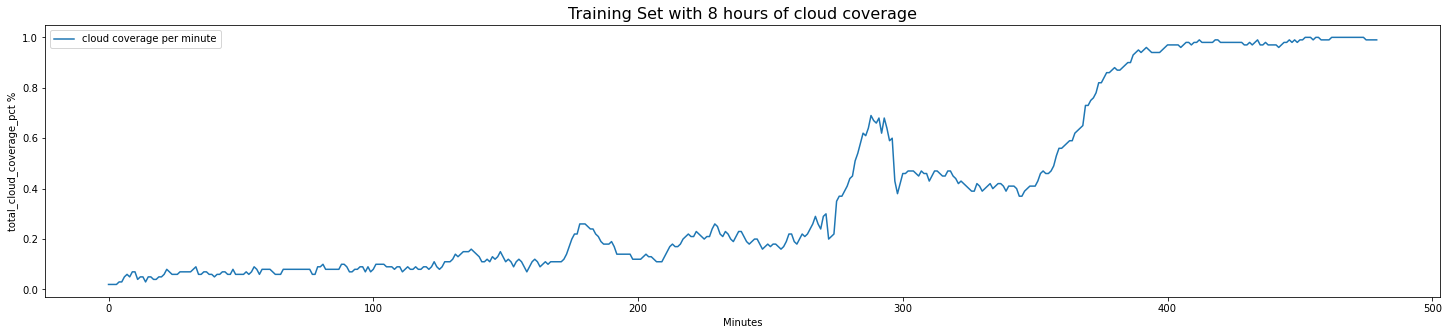

In [10]:
print("Univariate Training Set size for only 8 hours of data in minutes", train.shape)

plt.figure(figsize=(25,5))
plt.plot(train[0, :, -1], label="cloud coverage per minute")
plt.xlabel("Minutes")
plt.ylabel("total_cloud_coverage_pct %")
plt.legend()
plt.title("Training Set with 8 hours of cloud coverage", fontsize=16)
plt.show()

## Sampling and Standard Scaling Dataset
### Input feed 35 mins and Predicting next 30 mins

In [11]:
INPUT_DURATION_MINS = 60
PRED_DURATION_MINS = 120

train_x , train_y = to_supervised(train, INPUT_DURATION_MINS,  PRED_DURATION_MINS)
print("Training shape: X",train_x.shape," y", train_y.shape)

test_x, test_y = to_supervised(test, INPUT_DURATION_MINS,  PRED_DURATION_MINS)
print("Test shape: X",test_x.shape," y", test_y.shape)

#Standard Scaling
scaler , train_x_transformed, test_x_transformed = fit_transform_standard_scaler(train_x, test_x)
scaler.inverse_transform(test_x_transformed)[-1, 10, :], test_x[-1, 10, :], test_y[-1]

Training shape: X (100534, 60, 15)  y (100534, 4)
Test shape: X (9632, 60, 15)  y (9632, 4)


(array([ 2.4956700e+02, -9.8909000e-02,  1.5144251e+02, -6.6220000e+00,
        -7.4610000e+00, -8.9610000e+00,  8.1500000e+01,  3.7000000e+00,
         6.0520000e+01,  8.1392000e+02,  0.0000000e+00,  8.1000000e-01,
         1.0000000e+00,  6.5860000e-01,  9.8000000e-01]),
 array([ 2.4956700e+02, -9.8909000e-02,  1.5144251e+02, -6.6220000e+00,
        -7.4610000e+00, -8.9610000e+00,  8.1500000e+01,  3.7000000e+00,
         6.0520000e+01,  8.1392000e+02,  0.0000000e+00,  8.1000000e-01,
         1.0000000e+00,  6.5860000e-01,  9.8000000e-01]),
 array([0.98, 0.98, 0.99, 0.99]))

Training size: Input shape (100534, 60, 15) , Output shape (100534, 4)


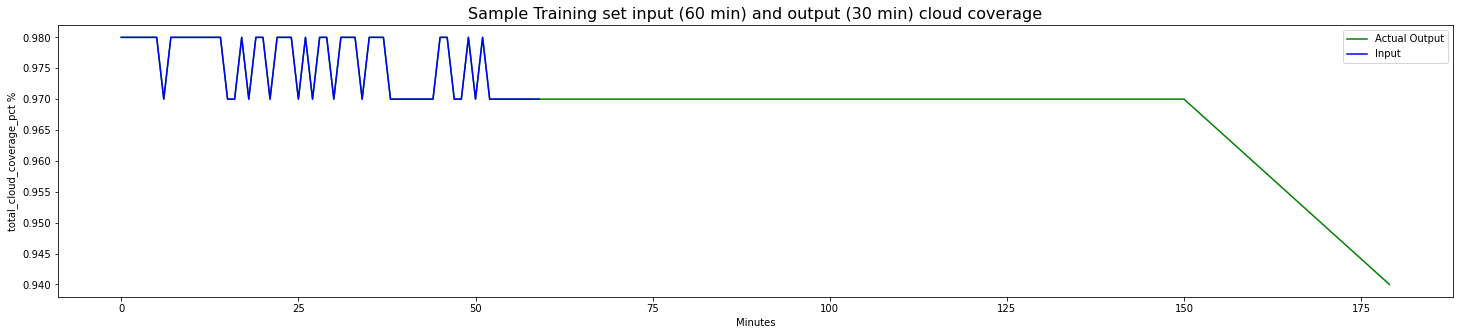

In [12]:

print("Training size: Input shape", train_x.shape, ", Output shape", train_y.shape)
plt.figure(figsize=(25,5))

item = 300*2

plt.plot(np.concatenate([train_x[item, :, -1].flatten(), 
                         np.linspace(train_x[item, -1, -1], train_y[item][0], 30),
                         np.linspace(train_y[item][0], train_y[item][1], 30),
                         np.linspace(train_y[item][1], train_y[item][2], 30),
                         np.linspace(train_y[item][2], train_y[item][3], 30)]), 'g-', label="Actual Output")

plt.plot(train_x[item, :, -1].flatten(), 'b-', label="Input")
plt.xlabel("Minutes")
plt.ylabel("total_cloud_coverage_pct %")
plt.legend()
plt.title("Sample Training set input ({} min) and output ({} min) cloud coverage".format(INPUT_DURATION_MINS,PRED_DURATION_MINS), fontsize=16)
plt.show()

#### 1) LSTM_1_V1 - LSTM with 1 layer

In [13]:
tf.random.set_seed(EXPERIEMENT_SEED)
# define parameters
verbose, epochs, batch_size = 0, 10, 350
n_timesteps, n_features, n_outputs = train_x_transformed.shape[1], train_x_transformed.shape[2], train_y.shape[1]
# define model
model = Sequential()
model.add(LSTM(200, activation='sigmoid', input_shape=(n_timesteps, n_features)))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(n_outputs, activation='sigmoid'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

print(model.summary())
history = model.fit(train_x_transformed, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x_transformed, test_y))

weather_models['LSTM_1_V1'] = (model,history)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               172800    
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 193,304
Trainable params: 193,304
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
288/288 [==============================] - 130s 428ms/step - loss: 0.1475 - mae: 0.1475 - val_loss: 0.1007 - val_mae: 0.1007
Epoch 2/10
288/288 [==============================] - 121s 421ms/step - loss: 0.1166 - mae: 0.1166 - val_loss: 0.0981 - val_mae: 0.0981
Epoch 3/10
288/288 [==============================] - 122s 424ms/step - loss: 0.1141 - mae: 0.1141 - va

In [13]:
model = tf.keras.models.load_model('models/full/LSTM_1_V1_V1')

In [14]:
test_pred_y = model.predict(test_x_transformed)
train_pred_y = model.predict(train_x_transformed)
print("Prediction Shapes: Train {}, Test {} \n".format(train_pred_y.shape, test_pred_y.shape))

Prediction Shapes: Train (100534, 4), Test (9632, 4) 



In [15]:
train_rmse_scores, train_mae_scores= evaluate_forecasts_daily_eod_prediction(train_pred_y , train_y, days_sampled=train.shape[0])
test_rmse_scores, test_mae_scores= evaluate_forecasts_daily_eod_prediction(test_pred_y , test_y, days_sampled=test.shape[0])

print("Train --> mse: ", (train_rmse_scores), ", mae: ",(train_mae_scores))
print("Test --> mse: ", (test_rmse_scores), ", mae: ",(test_mae_scores))

Train --> mse:  [14.355345315143426, 18.535928442711047, 19.537253118401225, 23.23373871164062] , mae:  [8.964687163467538, 11.468676737414864, 12.355359637987116, 15.165437275153431]
Test --> mse:  [19.896725171688697, 25.352664857660972, 24.333576123522352, 29.932243301915218] , mae:  [12.390704314224422, 15.815802225843074, 15.945378256030379, 19.96925679873675]


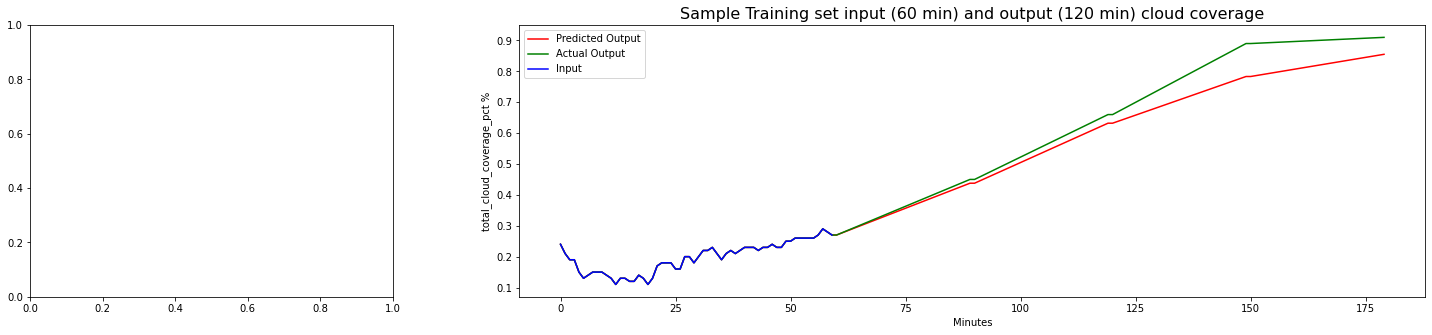

In [52]:
plot_model_evaluation(None, test_x, test_pred_y, test_y, (300*2))

#### 2) LSTM_2_V1 - LSTM with 2 layers

In [ ]:
tf.random.set_seed(EXPERIEMENT_SEED)
# define parameters
verbose, epochs, batch_size = 0, 10, 180
n_timesteps, n_features, n_outputs = train_x_transformed.shape[1], train_x_transformed.shape[2], train_y.shape[1]
# define model
model = Sequential()
model.add(LSTM(100, activation='sigmoid', input_shape=(n_timesteps, n_features), return_sequences = True))
model.add(LSTM(50, activation='sigmoid', input_shape=(n_timesteps, n_features), return_sequences = False))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(n_outputs, activation='sigmoid'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

print(model.summary())
history = model.fit(train_x_transformed, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x_transformed, test_y))

weather_models['LSTM_2_V1'] = (model,history)

In [ ]:
test_pred_y = model.predict(test_x_transformed)
train_pred_y = model.predict(train_x_transformed)
print("Prediction Shapes: Train {}, Test {} \n".format(train_pred_y.shape, test_pred_y.shape))

train_rmse_scores, train_mae_scores= evaluate_forecasts_daily_eod_prediction(train_pred_y , train_y, days_sampled=train.shape[0])
test_rmse_scores, test_mae_scores= evaluate_forecasts_daily_eod_prediction(test_pred_y , test_y, days_sampled=test.shape[0])

print("Train --> mse: ", (train_rmse_scores), ", mae: ",(train_mae_scores))
print("Test --> mse: ", (test_rmse_scores), ", mae: ",(test_mae_scores))

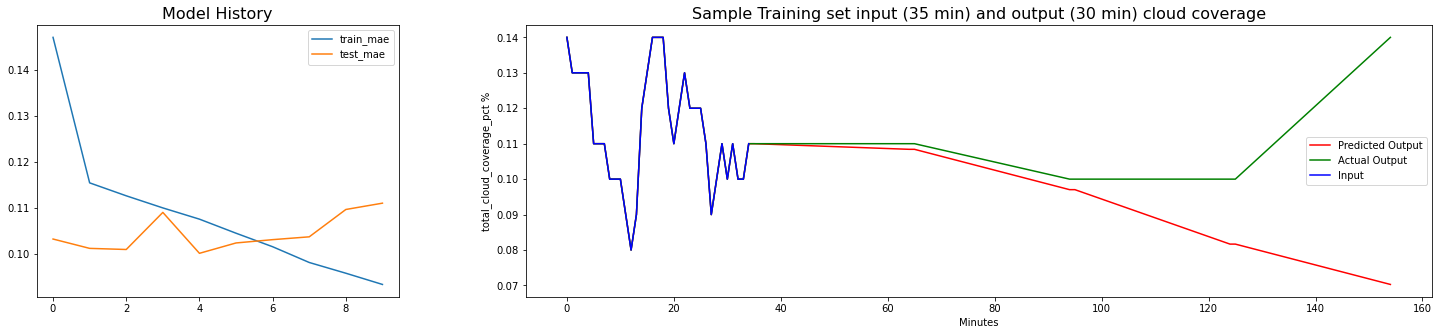

In [105]:
plot_model_evaluation(history, test_x, test_pred_y, test_y, (324 * 14))

## Saving models

In [55]:
for key, (model,history) in weather_models.items():
    model.save("models/full/"+key)

INFO:tensorflow:Assets written to: models/full/LSTM_1_V1\assets
